# Storm Petrels detection with **warbleR**
[warbleR](https://github.com/cran/warbleR/) is a very handy R package for bioacoustics. Full description can be found in [this](https://besjournals.onlinelibrary.wiley.com/doi/epdf/10.1111/2041-210X.12624) paper. Among other features, the package offers `autodetec` routine that can detect, after tuning of parameters, relevant acoustic signals. After extraction of *start* and *end* of a potential bird call, we pass this information to `specan` function that calculates audio features described in [documentation](https://www.rdocumentation.org/packages/warbleR/versions/1.1.12/topics/specan). 

## The goal
We are interested in what how many hypothetical calls are detected by **warbleR**. The R code can be found in [warbleR/autodetect.R](warbleR/autodetect.R).

## Load Python modules
`read_labels` offers a routine to load Excel spreadsheet and takes care of time conversion.

In [63]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
from sklearn.preprocessing import StandardScaler, Imputer
from birdutils import read_labels

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data paths
I am not particularly happy about hardcoding paths on my environment. We have a few options here:
* Live with that
* Store data on e.g. Google Cloud Storage with public access: everyone who has the link can access the data. It's not searchable / indexed, so no one will step on it by accident
* User private storage: Google account and permission is then needed to access the data

The question is strictly about `sthelena_labels.xls`. I do not suggest to share e.g. audio files. Output of my processing can be public.

In [2]:
# warbler_audio_features_path = '/mnt/data/Birdman/results/warbler/features_buffer_250ms.csv'
warbler_audio_features_path = '/mnt/data/Birdman/results/warbler/features_no_buffer.csv'
bird_calls_labels_path = '/mnt/data/Birdman/sthelena_labels.xls'

## Load the data
Load the data. I rename `start` and `end` column so that they match naming convention in the Excel label file. 

In [3]:
labels_dict = read_labels(bird_calls_labels_path)
labels = pd.concat(labels_dict, axis=0, ignore_index=True)
features = pd.read_csv(warbler_audio_features_path)
features = features.rename(columns={'start': 'Time Start', 'end': 'Time End'})

In [4]:
print('Number of signal found with warbleR:', len(features))

Number of signal found with warbleR: 1084


In [5]:
print('Number of labels per species:')
labels['Species'].value_counts()

Number of labels per species:


Storm Petrel    367
Brown Noddy      21
Name: Species, dtype: int64

## warbleR audio features
These audio features are calculated per region of interest, defined as the period between start and end of the call. The minimal length of the call has been defined as $\frac{1}{10}$ second while max is $1$ second.

In [6]:
features.head(3).T

,0,1,2
sound.files,STHELENA-02_20140605_200000_10,STHELENA-02_20140605_200000_10,STHELENA-02_20140605_200000_10
selec,1,2,3
duration,0.107313,0.164063,0.344063
meanfreq,2.8533,2.94531,2.79848
sd,1.14764,1.19305,1.05692
freq.median,2.82893,3.0122,2.84884
freq.Q25,2.3437,1.81098,2.15698
freq.Q75,3.01555,3.61585,3.09884
freq.IQR,0.671851,1.80488,0.94186
time.median,0.0487784,0.0911458,0.176227


`select` refers to the detected region on a [spectrogram](https://en.wikipedia.org/wiki/Spectrogram), in this case:

![Spectrogram](resources/STHELENA-02_20140605_200000_10.jpeg)

The red dashed lines denote start and end of the detected call. Mind that algorithm will miss some calls (false negative, analogous to Type I error), while also detect calls where there none (false positive, analogous to Type 2 error) - more on these on [Wikipedia](https://en.wikipedia.org/wiki/False_positives_and_false_negatives). Two caveats:
* The `autodetect` routine removes background and potentially also some bird calls. Do not try to infer true number of bird calls from such preprocessed spectrogram.
* The labels are not always accurate. It's easy to miss calls, especially if they're faint.

![false_positive_negative](resources/fp_fn_errors.png)

From *The Essential Guide to Effect Sizes: Statistical Power, Meta-Analysis, and the Interpretation of Research Results*

## Labels from the Excel file

In [7]:
labels_dict['STHELENA-02_20140605_200000_10'].head(5)

,Date,File Name,Type of Call,Time Start,Time End,Species,Notes
0,2014-06-05,STHELENA-02_20140605_200000_10,Flight Call,16.142,17.433,Storm Petrel,NaN
1,2014-06-05,STHELENA-02_20140605_200000_10,Flight Call,20.016,21.630,Storm Petrel,NaN
2,2014-06-05,STHELENA-02_20140605_200000_10,Flight Call,21.953,23.244,Storm Petrel,NaN
3,2014-06-05,STHELENA-02_20140605_200000_10,Flight Call,39.386,40.354,Storm Petrel,NaN
4,2014-06-05,STHELENA-02_20140605_200000_10,Flight Call,46.165,47.779,Storm Petrel,NaN


## The raw audio
In the example we have focused on first 50 seconds of this recording: STHELENA-02_20140605_200000_10.wav The widget below lets you play the audio

In [8]:
import IPython
IPython.display.Audio("resources/STHELENA-02_20140605_200000_10.mp3")

## Observations
* Around 9-12s: calls not present in labels. `warbleR` detects a call around 11s
* 16-17s: present in labels, not in `warbleR` 
* 20-23s: present in both
* 39-40s: present in both
* 41-42s: not present in both
* 46-47s: present in both

## Find overlap
Let's find how much overlap is between what `warbleR` detects and labels - and vice versa. The function finds if there is an overlap between the two. 

Overlap between labels and `warbleR` will tell us how many calls were detected (overlap = True) and how many missed (overlap = False). In turn, we will get **false negative** rate of a sort. 

Overlap between `warbleR` and labels will tell us how many calls were detected (overlap = True) and how many identified while not present in labels (overlap = False). In turn, we will get **false positive** rate of a sort. 

In [9]:
features['overlap'] = False
features['storm_petrel'] = False
labels['overlap'] = False
labels['storm_petrel'] = False

for filename in labels_dict.keys():
    df_label = labels[labels['File Name'] == filename]
    df_feat = features[features['sound.files'] == filename]
    for index1, row_label in df_label.iterrows():
        for index2, row_feat in df_feat.iterrows():
            feat_start = row_feat['Time Start']
            feat_end = row_feat['Time End']
            label_start = row_label['Time Start']
            label_end = row_label['Time End']
            overlap = (label_start <= feat_end) and (label_end >= feat_start)
            if overlap:
                labels.at[index1, 'overlap'] = True
                features.at[index2, 'overlap'] = True
                if row_label['Species'] == 'Storm Petrel':
                    labels.at[index1, 'storm_petrel'] = True
                    features.at[index2, 'storm_petrel'] = True

An alternative way to find overlap, on grouped objects - not used. It's much faster and concise, as it uses apply and vectorised operations, but might be difficult to read.

In [10]:
def find_overlap(group, **kwargs):
    """
    The double asterisk form of **kwargs is used to pass a keyworded, variable-length argument dictionary to a function. 
    """
    name = os.path.splitext(group.name)[0]
    
    label = kwargs['label']
    
    labels = label[name]
    label_start = labels['Time Start']
    label_end = labels['Time End']

    result = []

    for index, row in group.iterrows():
        start = row['Time Start']
        end = row['Time End']
        overlap = any((label_start <= end) & (label_end >= start))
        result.append(overlap)
    group['overlap'] = result

    return group

## Results for STHELENA-02_20140605_200000_10.
Let's study the first 50 seconds from the previous example. We are first selecting specific recording and then putting an upper limit on End Time.

In [11]:
warbler_labels_overlap_10 = features[features['sound.files'] == 'STHELENA-02_20140605_200000_10']
labels_warbler_overlap_10 = labels[labels['File Name'] == 'STHELENA-02_20140605_200000_10']
warbler_labels_overlap_10_50s = warbler_labels_overlap_10[warbler_labels_overlap_10['Time End'] < 50]
labels_warbler_overlap_10_50s = labels_warbler_overlap_10[labels_warbler_overlap_10['Time End'] < 50]

To avoid clutter, we select only a subset of columns

In [12]:
warbler_columns_no_features = ['sound.files', 'selec', 'duration', 'Time Start', 'Time End', 'overlap', 'storm_petrel']
warbler_labels_overlap_10_50s[warbler_columns_no_features]

,sound.files,selec,duration,Time Start,Time End,overlap,storm_petrel
0,STHELENA-02_20140605_200000_10,1,0.107313,11.170001,11.277314,False,False
1,STHELENA-02_20140605_200000_10,2,0.164063,20.205440,20.369502,True,True
2,STHELENA-02_20140605_200000_10,3,0.344063,20.546877,20.890940,True,True
3,STHELENA-02_20140605_200000_10,4,0.166625,20.950627,21.117252,True,True
4,STHELENA-02_20140605_200000_10,5,0.200875,21.149127,21.350002,True,True
5,STHELENA-02_20140605_200000_10,6,0.199250,21.385565,21.584815,True,True
6,STHELENA-02_20140605_200000_10,7,0.179063,22.147565,22.326627,True,True
7,STHELENA-02_20140605_200000_10,8,0.288625,22.450190,22.738815,True,True
8,STHELENA-02_20140605_200000_10,9,0.161438,22.783440,22.944878,True,True
9,STHELENA-02_20140605_200000_10,10,0.169563,22.985315,23.154878,True,True


Calculate `True Positive (tp)`  and `False Positive (fp)` rates.

In [13]:
Tp = sum(warbler_labels_overlap_10_50s['storm_petrel'])
Fp = len(warbler_labels_overlap_10_50s) - Tp
print('True positive in first 50s of STHELENA-02_20140605_200000_10:', Tp)
print('False positive in first 50s of STHELENA-02_20140605_200000_10:', Fp)

True positive in first 50s of STHELENA-02_20140605_200000_10: 17
False positive in first 50s of STHELENA-02_20140605_200000_10: 2


In [14]:
labels_warbler_overlap_10_50s

,Date,File Name,Type of Call,Time Start,Time End,Species,Notes,overlap,storm_petrel
52,2014-06-05,STHELENA-02_20140605_200000_10,Flight Call,16.142,17.433,Storm Petrel,NaN,False,False
53,2014-06-05,STHELENA-02_20140605_200000_10,Flight Call,20.016,21.630,Storm Petrel,NaN,True,True
54,2014-06-05,STHELENA-02_20140605_200000_10,Flight Call,21.953,23.244,Storm Petrel,NaN,True,True
55,2014-06-05,STHELENA-02_20140605_200000_10,Flight Call,39.386,40.354,Storm Petrel,NaN,True,True
56,2014-06-05,STHELENA-02_20140605_200000_10,Flight Call,46.165,47.779,Storm Petrel,NaN,True,True


In [15]:
fn = len(labels_warbler_overlap_10_50s) - sum(labels_warbler_overlap_10_50s['storm_petrel'])
print('False negative in first 50s of STHELENA-02_20140605_200000_10:', fn)

False negative in first 50s of STHELENA-02_20140605_200000_10: 1


## Results
Now that we have seen the algorithm at works on a small example, we can calculate the metrics for the complete labelled set. Knowing `tp`, `fp` and `fn`, we can calculate elementary metrics: 
* Accuracy and Precision: $\frac{T_p}{T_p+F_p}$ In this case they are one and the same, as we don't have `True Negative` scores.
* Recall: $\frac{T_p}{T_p+F_n}$

### Overall

In [16]:
Tp = sum(features['storm_petrel'])
Fp = len(features) - Tp
Fn = len(labels) - sum(labels['storm_petrel'])

print('True positive:', Tp)
print('False positive:', Fp)
print('False negative:', Fn)
print('Accuracy / Precision: {:.2f}%'.format(Tp / (Tp + Fp) * 100))
print('Recall: {:.2f}%'.format(Tp / (Tp + Fn) * 100))

True positive: 854
False positive: 230
False negative: 137
Accuracy / Precision: 78.78%
Recall: 86.18%


### Brown Noddy
There are very few calls from brown noddy

In [17]:
brown_noddy = labels[labels['Species'] == 'Brown Noddy']
brown_noddy

,Date,File Name,Type of Call,Time Start,Time End,Species,Notes,overlap,storm_petrel
32,2014-06-05,STHELENA-02_20140605_200000_1,Roosting,312.824,319.927,Brown Noddy,NaN,False,False
33,2014-06-05,STHELENA-02_20140605_200000_1,Roosting,322.187,326.383,Brown Noddy,NaN,False,False
34,2014-06-05,STHELENA-02_20140605_200000_1,Roosting,329.612,336.391,Brown Noddy,Call fades out,False,False
36,2014-06-05,STHELENA-02_20140605_200000_1,Roosting,386.107,394.501,Brown Noddy,NaN,False,False
38,2014-06-05,STHELENA-02_20140605_200000_1,Roosting,412.257,414.194,Brown Noddy,NaN,False,False
44,2014-06-05,STHELENA-02_20140605_200000_1,Roosting,492.319,495.548,Brown Noddy,NaN,False,False
51,2014-06-05,STHELENA-02_20140605_200000_1,Roosting,545.909,554.626,Brown Noddy,NaN,False,False
135,2014-06-05,STHELENA-02_20140605_200000_2,Roosting,0.000,3.551,Brown Noddy,NaN,True,False
137,2014-06-05,STHELENA-02_20140605_200000_2,Roosting,12.913,19.047,Brown Noddy,NaN,True,False
150,2014-06-05,STHELENA-02_20140605_200000_2,Roosting,65.696,68.118,Brown Noddy,NaN,False,False


In [18]:
brown_noddy_overlap = sum(brown_noddy['overlap'])
print('{} out of {} of Brown Noddy calls have been identified by warbleR, which is {:.2f}% of total'.
      format(brown_noddy_overlap, len(brown_noddy), brown_noddy_overlap / len(brown_noddy) * 100))

8 out of 21 of Brown Noddy calls have been identified by warbleR, which is 38.10% of total


Since there are only 21 calls, we cannot draw any meaningful conclusions. It's clear though that the algorithm, after some tuning, is rather storm petrels specific: *storm petrels* score 78% while *brown noddy* only 38%.

---

# False positives? 

Are the numbers any good? It's a matter of what we are looking to achieve. This basic algorithm has higher recall than precision. 78% precision tells us that, statistically speaking, it finds more calls then there actually are - in this case it found 232 more calls than in labels. Some on them will be simply mistakes, while some will be actual calls that were missed in labels. It's worth looking into these. Please note that a single label in Excel can be easily translated into, say, 6 calls picked up by the algorithm, if it consitutes of 6 consecutive calls.

Also, the algorithm has to not bad recall (sensitivity): once it detects the signal, there's 86% probability that it's a storm petrel (in these conditions)

## False positive examples

In [19]:
fp_df = features[features['storm_petrel'] == False][warbler_columns_no_features]
fp_df.head(5)

,sound.files,selec,duration,Time Start,Time End,overlap,storm_petrel
0,STHELENA-02_20140605_200000_10,1,0.107313,11.170001,11.277314,False,False
15,STHELENA-02_20140605_200000_10,16,0.119563,40.451754,40.571317,False,False
19,STHELENA-02_20140605_200000_10,20,0.124688,137.379203,137.503890,False,False
20,STHELENA-02_20140605_200000_10,21,0.179313,161.179893,161.359205,False,False
21,STHELENA-02_20140605_200000_10,22,0.149500,192.057771,192.207271,False,False


### Path to audio data
The stereo recordings have been converted to mono and downsampled to 16khz for ease of experimenting. In future we might use original recordings, but my experience tells other factors play much more important role. We leave fine-tuning for later.

In [20]:
path_to_storm_petrels = '/mnt/data/Birdman/16khz/'
output_dir = os.path.join(path_to_storm_petrels, 'fp')

`extract_call` takes call metadata, extracts the relevant audio piece and saves it to audio file.

In [21]:
def extract_call(call, **kwargs):
    filename = call['sound.files'] + '.wav'
    path = os.path.join(kwargs['path'], filename )
    rate, data = wavfile.read(path)
    
    start = int((call['Time Start'] - kwargs['buffer']) * rate)
    end = int((call['Time End'] + kwargs['buffer']) * rate)
    data = data[start:end]
    
    if 'out' in kwargs:
        os.makedirs(kwargs['out'], exist_ok=True)
        name = call['sound.files'] + '_' + str(call['selec']) + '.wav'
        outpath = os.path.join(kwargs['out'], name)
        wavfile.write(outpath, rate, data)
    
    return data

The two lines below, respectively, save the audio and features to a file

In [22]:
# result = fp_df.apply(extract_call, axis=1, path=path_to_storm_petrels, buffer=0.25, out=output_dir)
# features.to_csv('features_warbler_no_buffer.csv')

## Manual investigation of calls
I manually checked all false positives and noted *ground truth*. Extra columns that have been added to output originally produced by `warbleR`:
* `overlap`: we have calculated it in a previous paragraphs by checking overlap with labels
* `storm_petrel`: presence of storm petrel call according to labels
* `storm_petrel_ground_truth`: the ground truth established by checking all false positives. Note that to find proper ground truth, I'd have to check all recordings, not just regions selected by `warbleR`
* `brown_noddy`: presence of brown noddy call according to labels OR found in manual check

In [99]:
features = pd.read_csv('/mnt/data/Birdman/results/warbler/features_warbler_buffer_250ms.csv', index_col=0)
features.iloc[:,:9].head(5)

,sound.files,selec,overlap,storm_petrel,storm_petrel_ground_truth,brown_noddy,Time Start,Time End,duration
index,,,,,,,,,
0,STHELENA-02_20140605_200000_10,1,False,0,1,0,10.920001,11.527314,0.607313
1,STHELENA-02_20140605_200000_10,2,True,1,1,0,19.955440,20.619502,0.664063
2,STHELENA-02_20140605_200000_10,3,True,1,1,0,20.296877,21.140940,0.844063
3,STHELENA-02_20140605_200000_10,4,True,1,1,0,20.700627,21.367252,0.666625
4,STHELENA-02_20140605_200000_10,5,True,1,1,0,20.899127,21.600002,0.700875


In [24]:
Tp_gt = sum(features['storm_petrel_ground_truth'])
Fp_gt = len(features) - Tp_gt

print('True positive (ground truth):', Tp_gt)
print('False positive (ground truth):', Fp_gt)
print('Precision (ground truth): {:.2f}%'.format(Tp_gt / (Tp_gt + Fp_gt) * 100))
print('New (wrt labels) storm petrel calls discovered:', Fp - Fp_gt)

True positive (ground truth): 982
False positive (ground truth): 102
Precision (ground truth): 90.59%
New (wrt labels) storm petrel calls discovered: 128


### **Conclusion**: half of false positives turned out to be true positive!
---

# Audio characteristic of calls
Now that we understand better where we have storm petrel calls, let's check their audio characteristic

In [68]:
petrels = features[features['storm_petrel_ground_truth'] == 1]
noise = features[features['storm_petrel_ground_truth'] == 0]

In [69]:
feature_names = ['meanfreq', 'sd', 'freq.median', 'freq.Q25', 'freq.Q75', 'freq.IQR', 'time.median', 'time.Q25', 'time.Q75', 'time.IQR', 
                 'skew',  'kurt', 'sp.ent', 'time.ent', 'entropy', 'sfm', 'meanfun', 'minfun', 'maxfun', 'meandom', 'mindom', 'maxdom', 
                 'dfrange', 'modindx', 'startdom', 'enddom', 'dfslope', 'meanpeakf', 'peakf']

In [70]:
petrel_features = petrels[feature_names]
noise_features = noise[feature_names]

In [71]:
petrel_features.describe().T

,count,mean,std,min,25%,50%,75%,max
meanfreq,982.0,2.728596,0.195450,2.038590,2.610405,2.715565,2.830605,3.643788
sd,982.0,1.117594,0.151754,0.785409,1.011516,1.094598,1.198213,1.818760
freq.median,982.0,2.660556,0.235561,1.582573,2.530839,2.643170,2.768138,3.948985
freq.Q25,982.0,2.035085,0.320272,1.252862,1.800548,2.050442,2.260748,3.064304
freq.Q75,982.0,3.136562,0.317660,2.221577,2.938562,3.066591,3.276469,4.392531
freq.IQR,982.0,1.101477,0.384830,0.324324,0.814525,1.054227,1.334120,2.984592
time.median,982.0,0.339227,0.087206,0.083150,0.295490,0.334243,0.378000,0.738803
time.Q25,982.0,0.204377,0.094487,0.016632,0.124131,0.180577,0.288417,0.486325
time.Q75,982.0,0.491649,0.112396,0.173479,0.389196,0.494889,0.556622,1.014839
time.IQR,982.0,0.287273,0.089492,0.041032,0.239503,0.288514,0.346724,0.633260


In [47]:
noise_features.describe().T

,count,mean,std,min,25%,50%,75%,max
meanfreq,102.0,2.841197,0.183950,2.312464,2.725747,2.816775,3.021934,3.133814
sd,102.0,1.675167,0.145909,1.131204,1.683698,1.705790,1.761159,1.806238
freq.median,102.0,2.253447,0.264111,1.811001,2.046055,2.161033,2.558956,3.081328
freq.Q25,102.0,1.446120,0.158454,1.278400,1.321040,1.354679,1.583652,2.018013
freq.Q75,102.0,3.926626,0.423113,2.485957,3.770793,4.028050,4.271944,4.357886
freq.IQR,102.0,2.480507,0.485134,0.891342,2.454118,2.692837,2.736048,2.910363
time.median,102.0,0.372203,0.093406,0.222079,0.315155,0.339420,0.386736,0.704441
time.Q25,102.0,0.221188,0.075741,0.057576,0.165246,0.204918,0.272721,0.447920
time.Q75,102.0,0.525758,0.138570,0.346752,0.437837,0.485956,0.550821,1.044516
time.IQR,102.0,0.304570,0.111767,0.098578,0.247419,0.312630,0.357921,0.672053


By looking at these tables side by side, we can see that there is a difference between the two. Let's make a [box plot](https://en.wikipedia.org/wiki/Box_plot). We will also standardize features by removing the mean and scaling to unit variance. Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set.

First make sure there are no missing values in our features.

In [110]:
features[feature_names].isna().any()

meanfreq       False
sd             False
freq.median    False
freq.Q25       False
freq.Q75       False
freq.IQR       False
time.median    False
time.Q25       False
time.Q75       False
time.IQR       False
skew           False
kurt           False
sp.ent         False
time.ent       False
entropy        False
sfm            False
meanfun        False
minfun         False
maxfun         False
meandom        False
mindom         False
maxdom         False
dfrange        False
modindx        False
startdom       False
enddom         False
dfslope        False
meanpeakf      False
peakf          False
dtype: bool

Clearly there are some missing values in *fundamental frequency* feature group. We will replace them with median for the respective group.

In [107]:
features[['meanfun', 'minfun', 'maxfun']] = features.groupby('storm_petrel_ground_truth')[['meanfun', 'minfun', 'maxfun']].transform(lambda x: x.fillna(x.median()))

It's time to scale our features for future processing.

In [113]:
scaler = StandardScaler()
features[feature_names] = scaler.fit_transform(features[feature_names])

In [115]:
features[feature_names].head(10)

,meanfreq,sd,freq.median,freq.Q25,freq.Q75,freq.IQR,time.median,time.Q25,time.Q75,time.IQR,...,meandom,mindom,maxdom,dfrange,modindx,startdom,enddom,dfslope,meanpeakf,peakf
index,,,,,,,,,,,,,,,,,,,,,
0,0.605809,0.234951,0.588000,0.863556,-0.551259,-0.933256,-0.673910,-0.694305,-1.188110,-0.790350,...,0.381440,-0.030387,-0.303455,-0.303383,-0.555011,-0.743497,-0.375043,0.306693,0.682728,-0.144378
1,0.709057,0.130947,0.808148,-0.496769,0.877566,0.935869,0.301354,1.135952,1.181905,0.335680,...,-0.522725,-0.030387,0.590859,0.590941,-0.546255,-0.825411,1.694375,1.731429,1.085865,-0.057546
2,0.144344,-0.517899,0.760415,0.309183,-0.250840,-0.372206,1.599601,1.310856,1.818576,0.958689,...,1.001678,-0.030387,0.590859,0.590941,1.014510,2.614973,-0.375043,-1.773794,1.005237,-0.041892
3,-0.658580,-0.531646,0.173457,-0.870655,-0.581332,0.131370,-0.335324,-0.887759,0.276022,1.245089,...,0.455144,-0.030387,0.021750,0.021826,1.978112,1.795834,-0.657236,-1.835532,0.843983,-0.128100
4,-0.876036,-0.300070,-0.074656,-1.125494,-0.552525,0.311470,0.232031,-0.441642,0.784797,1.432973,...,-0.160244,-0.030387,0.184353,0.184430,1.152063,-0.825411,-0.280979,0.398064,0.440847,-0.121541
5,-0.448639,-0.593979,-0.119415,0.461872,0.182423,-0.159370,-0.523255,-0.976831,-1.151436,-0.458400,...,-1.093938,-0.030387,-0.303455,-0.303383,1.245450,-0.825411,-0.751301,0.100985,-1.655462,-0.080288
6,-0.944119,-0.867869,-0.262868,-0.680512,-0.525279,0.052200,0.343651,1.437172,0.089221,-1.342072,...,-0.486520,-0.030387,-0.303455,-0.303383,-0.332826,-0.825411,0.001215,0.591579,0.440847,-0.177049
7,-0.611657,-0.819654,-0.143628,0.206598,-0.468423,-0.462868,-0.527998,-1.597294,-0.017052,1.594770,...,0.899899,-0.030387,-0.303455,-0.303383,0.893020,0.976695,-0.375043,-0.849495,0.440847,-0.144312
8,-0.135755,-0.990307,0.188342,1.036586,-0.640771,-1.105342,-0.318948,-0.703703,0.153838,0.905329,...,1.136624,-0.030387,0.184353,0.184430,-0.375689,1.468178,0.095279,-1.095221,0.521474,-0.165492


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb2ecc67c88>,
      dtype=object)

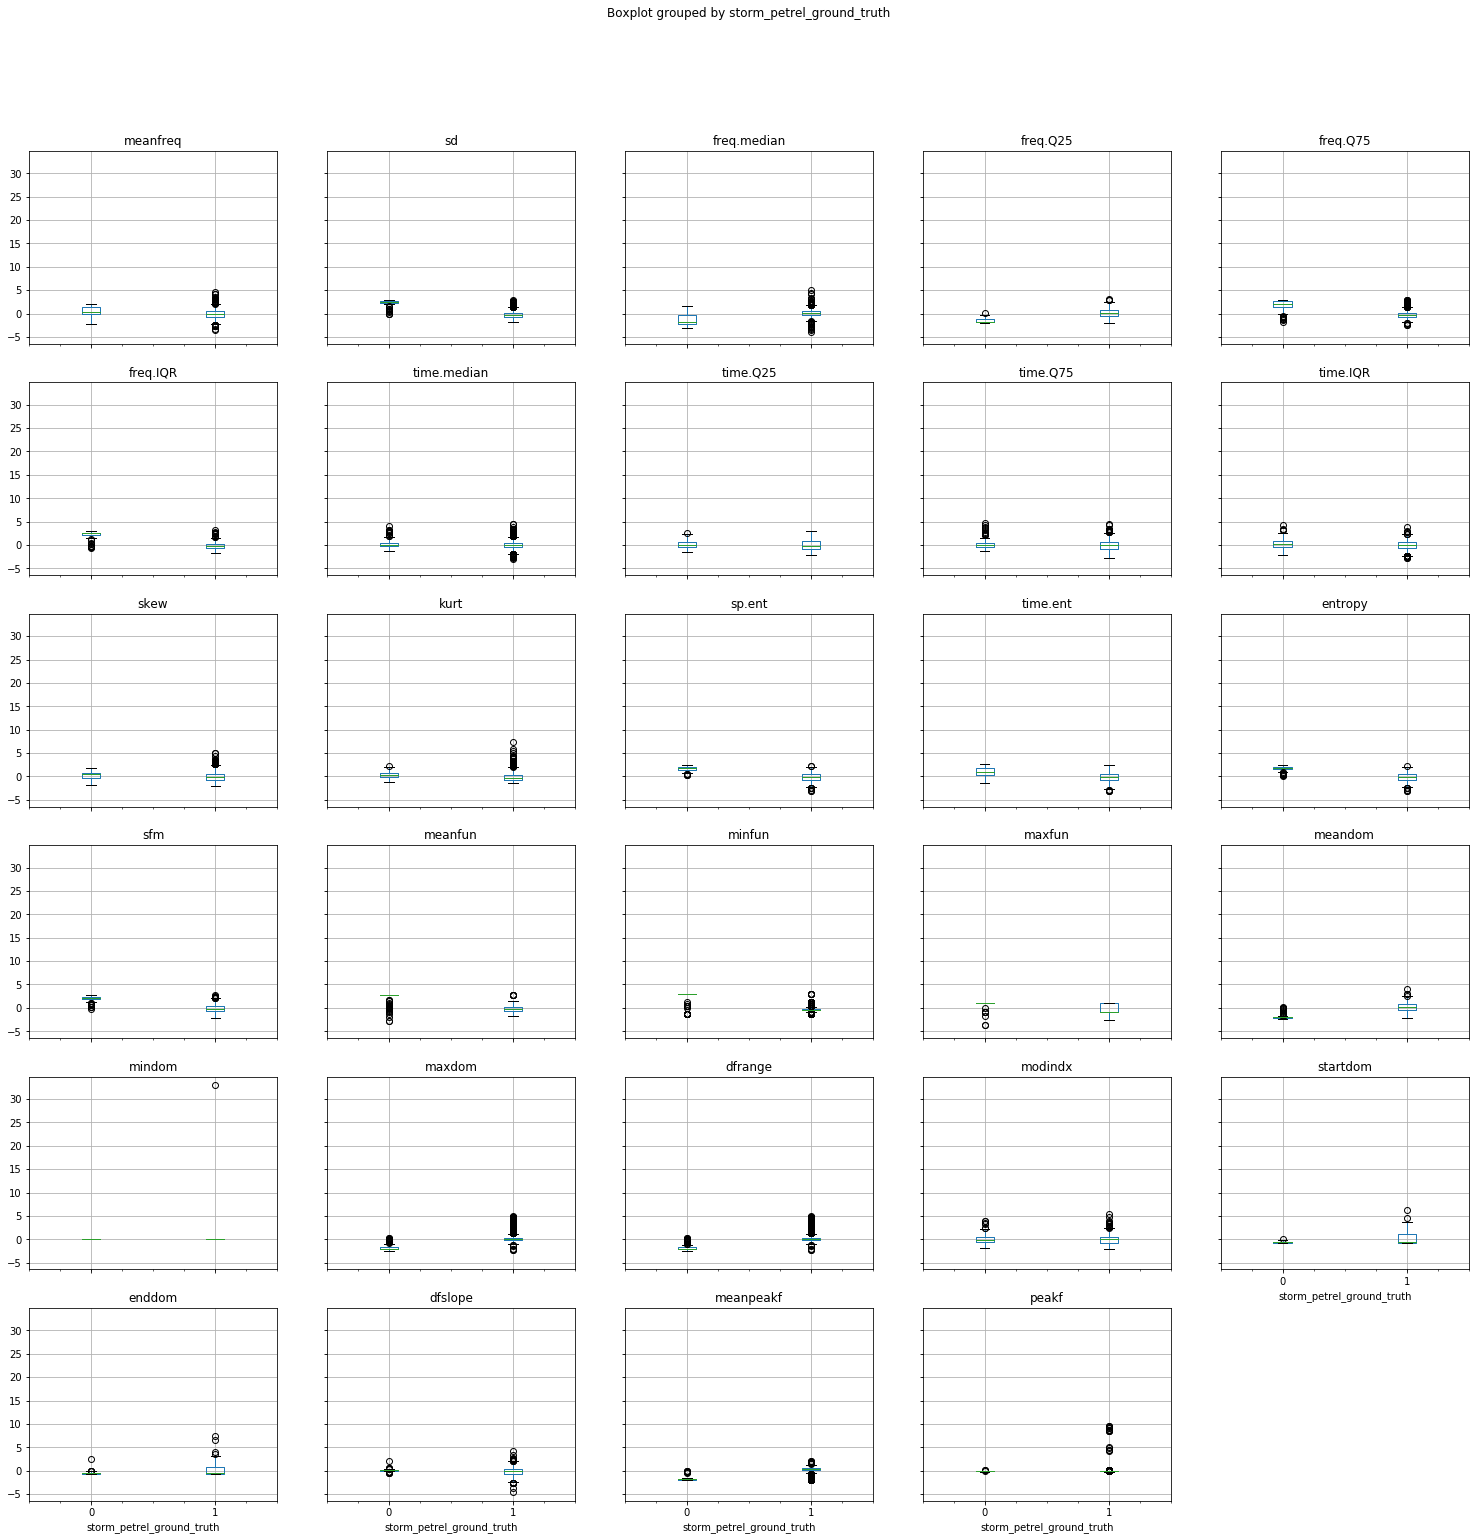

In [114]:
# fig, ax_new = plt.subplots(5,6, sharey=False)
# features[feature_names].boxplot(by='storm_petrel_ground_truth', figsize=(25,25), ax=ax_new, layout=(5,6))
features.boxplot(column=feature_names, by='storm_petrel_ground_truth', figsize=(25,25))

In [29]:
petrels.head(3).T

index,0,1,2
sound.files,STHELENA-02_20140605_200000_10,STHELENA-02_20140605_200000_10,STHELENA-02_20140605_200000_10
selec,1,2,3
overlap,False,True,True
storm_petrel,0,1,1
storm_petrel_ground_truth,1,1,1
brown_noddy,0,0,0
Time Start,10.92,19.9554,20.2969
Time End,11.5273,20.6195,21.1409
duration,0.607313,0.664063,0.844063
meanfreq,2.85853,2.87887,2.76763
